# DATA620 - Project 2

## Goal:

Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
What can you infer about each of the distinct groups?
You may work in a small group on the project.


# Introduction

For the purposes of this project, I decided to analyze the Marvel Cinematic Universe (MCU) social network. Growing up, I was a big fan of comic books and kept up with the movies consistently. However, over time, I have started to fall behind on the MCU content, and my knowledge has certainly declined. I saw this project as an opportunity to analyze a large set of data that I really enjoy. I saw several MCU social network analyses online, however very few of them were bipartite datasets. I was inspired by the Marvel Chronology Project (https://www.chronologyproject.com/) which looks at several pieces of data to observe character popularity. To make this a large 2-node network dataset, I decided to take a slightly different approach. I used a dataset uploaded to fivethirtyeight, which scrapes data from the MCU wiki page. This dataset collects several pieces of information: 'page_id', 'name', 'urlsug', 'ID', 'ALIGN', 'EYE', 'HAIR', 'SEX', 'GSM', 'ALIVE', 'APPEARANCES' , and 'Year'.

Data Source: https://fivethirtyeight.datasettes.com/fivethirtyeight/comic-characters~2Fmarvel-wikia-data

Below is the analysis for the alignment of Marvel Cinematic Universe's characters. The objective here is to use varying clustering techniques and centrality measures to analyze the MCU characters. Through this project, we can see which characters are the most popular, and potentially gain some insight into what kind of character is generally popularized -- are supervillians more necessary than superheroes to make a good story?

# Installing Packages


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.layout import bipartite_layout
import numpy as np
import matplotlib.colors as mcolors



I first started by loading the necessary packages. These libraries are useful for data analysis, visualization, and network analysis.

# Loading Dataset

In [3]:
url = 'https://raw.githubusercontent.com/rkasa01/DATA620_Project-2/main/comic-characters%7E2Fmarvel-wikia-data.csv'
data =pd.read_csv(url)
print(data.head())

print(data.columns)

   rowid  page_id                                 name  \
0      1     1678            Spider-Man (Peter Parker)   
1      2     7139      Captain America (Steven Rogers)   
2      3    64786  Wolverine (James \"Logan\" Howlett)   
3      4     1868    Iron Man (Anthony \"Tony\" Stark)   
4      5     2460                  Thor (Thor Odinson)   

                                   urlslug                ID  \
0              \/Spider-Man_(Peter_Parker)   Secret Identity   
1        \/Captain_America_(Steven_Rogers)   Public Identity   
2  \/Wolverine_(James_%22Logan%22_Howlett)   Public Identity   
3    \/Iron_Man_(Anthony_%22Tony%22_Stark)   Public Identity   
4                    \/Thor_(Thor_Odinson)  No Dual Identity   

                ALIGN         EYE        HAIR              SEX  GSM  \
0     Good Characters  Hazel Eyes  Brown Hair  Male Characters  NaN   
1     Good Characters   Blue Eyes  White Hair  Male Characters  NaN   
2  Neutral Characters   Blue Eyes  Black Hair  Male C

This dataframe contains information about MCU characters, including attributes like name, identity (ID), alignment, appearance details (eye and hair color), sex, GSM (gender and sexual orientation), alive status, number of appearances, and year of first appearance. It consists of 13 columns, with 'name' being the unique identifier for each character, and 'APPEARANCES' representing the most frequently occurring attribute.

# Assigning Nodes and Edges

In [4]:
character_appearances = data[['name', 'APPEARANCES']].copy() # to visualize network with character appearances

character_appearances.dropna(subset=['APPEARANCES'], inplace=True)

G_character_appearances = nx.Graph()

for _, row in character_appearances.iterrows():
    character = row['name']
    appearances = row['APPEARANCES']
    G_character_appearances.add_edge(character, 'Comic Appearances', weight=appearances)

print("Number of nodes:", G_character_appearances.number_of_nodes())
print("Number of edges:", G_character_appearances.number_of_edges())


Number of nodes: 1001
Number of edges: 1000


I wanted to begin by visualizing the initial dataset. To do this, I had to assign the nodes and edges. I used the number of appearances as the weight. Using the "appearances" as the edge weight signifies that the number of appearances of a character also represents the strength of the relationship between that character and their corresponding alignment.

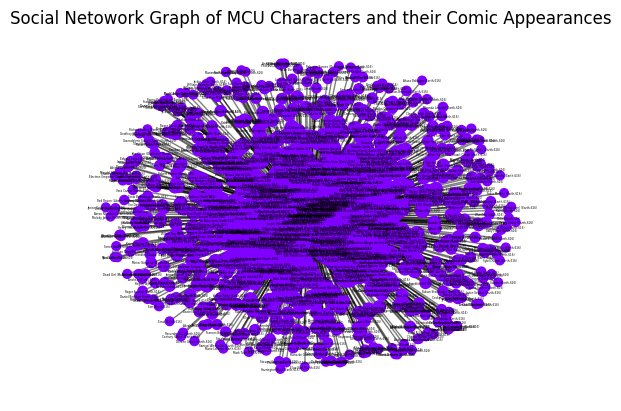

In [5]:
node_sizes = [sum(G_character_appearances[node][neighbor]['weight'] for neighbor in G_character_appearances.neighbors(node)) for node in G_character_appearances.nodes() if node != 'Comic Appearances'] # Calculate node sizes proportional to the sum of weights of incident edges for each node

pos = nx.spring_layout(G_character_appearances)

node_degrees = dict(G_character_appearances.degree())
rainbow_colors = [plt.cm.rainbow(node_degrees[node] / max(node_degrees.values())) for node in G_character_appearances.nodes() if node != 'Comic Appearances']
nx.draw_networkx_nodes(G_character_appearances, pos, nodelist=[node for node in G_character_appearances if node != 'Comic Appearances'],
                       node_size=node_sizes, node_color=rainbow_colors)

nx.draw_networkx_edges(G_character_appearances, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G_character_appearances, pos, font_size=2)

plt.title('Social Netowork Graph of MCU Characters and their Comic Appearances')
plt.axis('off')
plt.show()

This is a look at the MCU dataset as a network, before any sort of manipulation. There are over a thousand names being recorded and displayed in this network.

### Missing Data

In [6]:
character_alignment = data[['name', 'ALIGN', 'APPEARANCES']].copy() #columns selected
character_alignment.dropna(subset=['ALIGN', 'APPEARANCES'], inplace=True) # Drop rows with missing data in 'ALIGN' or 'APPEARANCES'

G_character_alignment = nx.Graph()

for G, row in character_alignment.iterrows(): #alignment and appearance weighted
    character = row['name']
    alignment = row['ALIGN']
    appearances = row['APPEARANCES']
    G_character_alignment.add_edge(character, alignment, weight=appearances)

print("Number of nodes:", G_character_alignment.number_of_nodes())
print("Number of edges:", G_character_alignment.number_of_edges())

print(character_alignment.head())


Number of nodes: 941
Number of edges: 938
                                  name               ALIGN  APPEARANCES
0            Spider-Man (Peter Parker)     Good Characters         4043
1      Captain America (Steven Rogers)     Good Characters         3360
2  Wolverine (James \"Logan\" Howlett)  Neutral Characters         3061
3    Iron Man (Anthony \"Tony\" Stark)     Good Characters         2961
4                  Thor (Thor Odinson)     Good Characters         2258


For the purposes of this project, I decided it was best to remove the rows that have any missing data in either 'ALIGN', or the charater's alignment, and/or the 'APPEARANCES', or the number of appearances. This is because we need both of these measures for this specific network analysis.

# Assigning MCU's Character Alignment

In [7]:
alignment_counts = {}

for alignment in ['Good Characters', 'Bad Characters', 'Neutral Characters']: #going through ea of the alignments
    alignment_counts[alignment] = character_alignment[character_alignment['ALIGN'] == alignment]['name'].nunique()

print("Total Characters by Alignment:")
for alignment, count in alignment_counts.items():
    print(f"{alignment}: {count}")

Total Characters by Alignment:
Good Characters: 547
Bad Characters: 240
Neutral Characters: 151


Here, I started by separating the characters according to their respective alignment. I created three groups: "Good Characters", "Bad Characters", and "Neutral Characters". At this point, there are 547 good caracters, 240 bad, and 151 neutral.

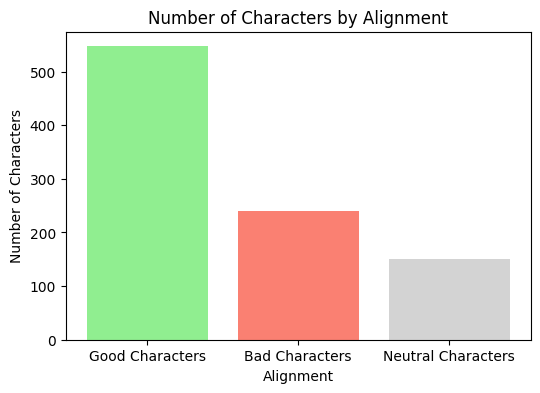

In [8]:
color_mapping = {
    'Good Characters': 'lightgreen',
    'Bad Characters': 'salmon',
    'Neutral Characters': 'lightgray'
}

def map_counts_to_colors(counts):
    colors = []
    for alignment, count in counts.items():
        colors.append(color_mapping.get(alignment, 'lightgray'))
    return colors
plt.figure(figsize=(6, 4))

alignment_counts = {}
for alignment in ['Good Characters', 'Bad Characters', 'Neutral Characters']:
    alignment_counts[alignment] = character_alignment[character_alignment['ALIGN'] == alignment]['name'].nunique()

node_colors = map_counts_to_colors(alignment_counts)

plt.bar(alignment_counts.keys(), alignment_counts.values(), color=node_colors)

plt.title('Number of Characters by Alignment')
plt.xlabel('Alignment')
plt.ylabel('Number of Characters')

plt.show()


Before visualizing the data in a network, I wanted to include a bar graph which visually demonstrates the differencs between the three.

# Data Visualizations

## Bipartite Network of MCU Characters and Their Alignment (Weighted by Appearances)

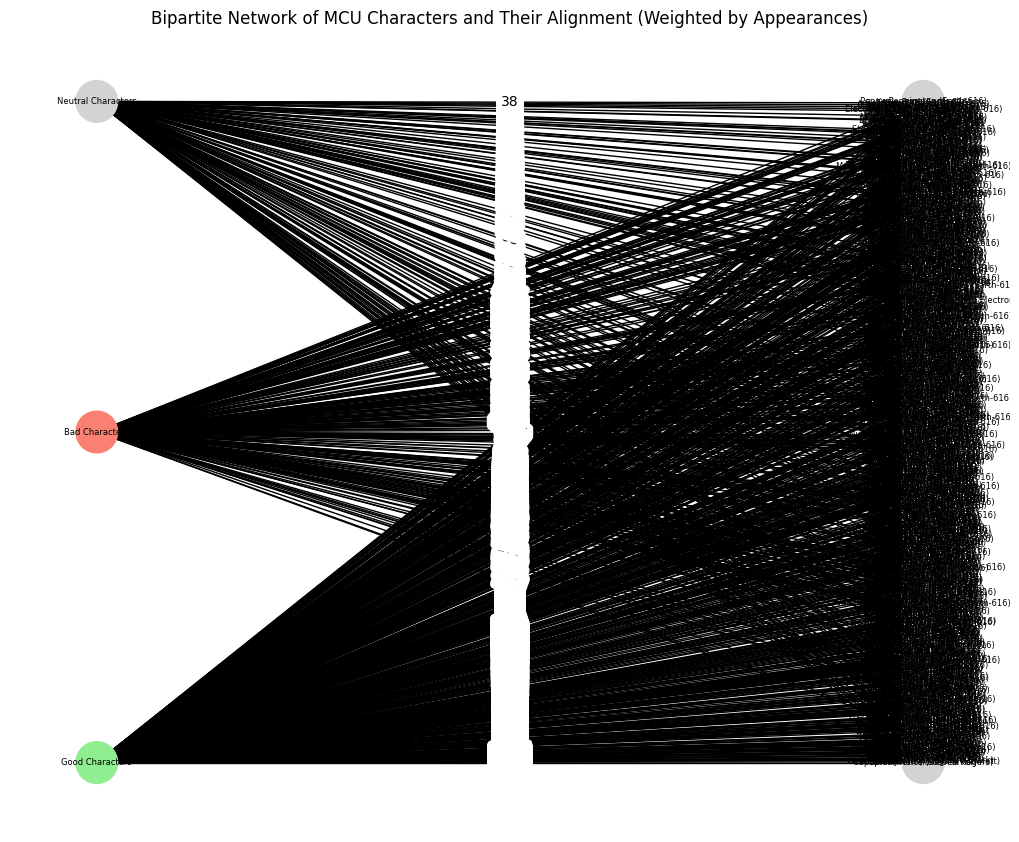

In [9]:
G_bipartite = nx.Graph()

for alignment in ['Good Characters', 'Bad Characters', 'Neutral Characters']: #align nodes
    G_bipartite.add_node(alignment, bipartite=0)

characters = character_alignment['name'].unique() #name nodes
for character in characters:
    G_bipartite.add_node(character, bipartite=1)

for alignment in ['Good Characters', 'Bad Characters', 'Neutral Characters']:
    alignment_characters = character_alignment[character_alignment['ALIGN'] == alignment]
    for _, row in alignment_characters.iterrows():
        character = row['name']
        weight = row['APPEARANCES']
        G_bipartite.add_edge(alignment, character, weight=weight)

np.random.seed(5)
pos = nx.bipartite_layout(G_bipartite, [alignment for alignment in ['Good Characters', 'Bad Characters', 'Neutral Characters']])

node_colors = [color_mapping.get(node, 'lightgray') for node in G_bipartite.nodes()]

plt.figure(figsize=(10, 8))
nx.draw(G_bipartite, pos, with_labels=True, node_color=node_colors, node_size=900, font_size=6)
nx.draw_networkx_edge_labels(G_bipartite, pos, edge_labels=nx.get_edge_attributes(G_bipartite, 'weight'))
plt.title('Bipartite Network of MCU Characters and Their Alignment (Weighted by Appearances)')
plt.show()

Due to the volume of data, it is difficult to see the names of the characters and which alignment group they belong to. What I like about this bipartite network graph, is that we can see the two groups very distinctly. Due to the frequency of lines connected from "Good Characters" to the names of the characters, I would infer that this is the more popular group. This could also mean that they make more MCU appearances due to their popularity.


## Social Network Graph of MCU Characters and Their Alignment (Weighted by Appearances

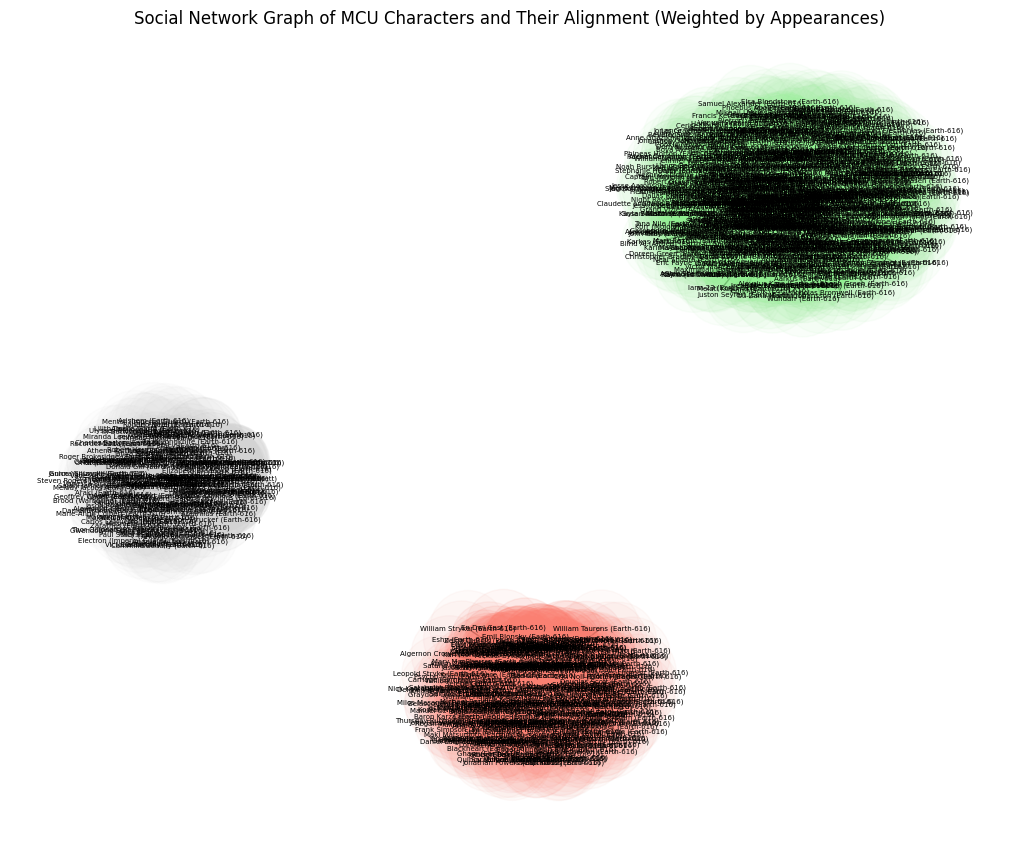

In [10]:
color_mapping = {
    'Good Characters': 'lightgreen',
    'Bad Characters': 'salmon',
    'Neutral Characters': 'lightgray'
}

G_bipartite = nx.Graph()

for alignment in ['Good Characters', 'Bad Characters', 'Neutral Characters']:
    G_bipartite.add_node(alignment, bipartite=0)

# Add nodes for each character
characters = character_alignment['name'].unique()
for character in characters:
    G_bipartite.add_node(character, bipartite=1)

# Add weighted edges connecting characters to their alignment
for alignment in ['Good Characters', 'Bad Characters', 'Neutral Characters']:
    alignment_characters = character_alignment[character_alignment['ALIGN'] == alignment]
    for _, row in alignment_characters.iterrows():
        character = row['name']
        weight = row['APPEARANCES']
        G_bipartite.add_edge(alignment, character, weight=weight)


np.random.seed(1)
pos = nx.fruchterman_reingold_layout(G_bipartite)

node_colors = []
for node in G_bipartite.nodes():
    if node in color_mapping:  # Assign colors to alignment nodes
        node_colors.append(color_mapping[node])
    else:  # Assign colors to character nodes
        alignment = [n for n in G_bipartite.neighbors(node) if n in color_mapping][0]  # Get the alignment of the character
        appearances = sum(character_alignment[character_alignment['name'] == node]['APPEARANCES'])
        alpha = min(1, appearances / 1000)  # Scale appearances to fit within the range [0, 1]
        color = mcolors.to_rgba(color_mapping[alignment], alpha=alpha)  # Set alpha level based on appearances
        node_colors.append(color)

plt.figure(figsize=(10, 8))
nx.draw(G_bipartite, pos, with_labels=True, node_color=node_colors, node_size=3000, font_size=5)
nx.draw_networkx_edge_labels(G_bipartite, pos, edge_labels=nx.get_edge_attributes(G_bipartite, 'weight'))
plt.title('Social Network Graph of MCU Characters and Their Alignment (Weighted by Appearances)')
plt.show()


Here, I assigned colors to each of the alignment groups. Red is for the bad characters, gray for the neutral, and green for the good. This separates them all into three dinstinct groups, which helps in visualizing the network and their associated froups.

#Reducing the Data

## Social Network Graph of MCU Characters and Their Alignment (Weighted by Appearances)

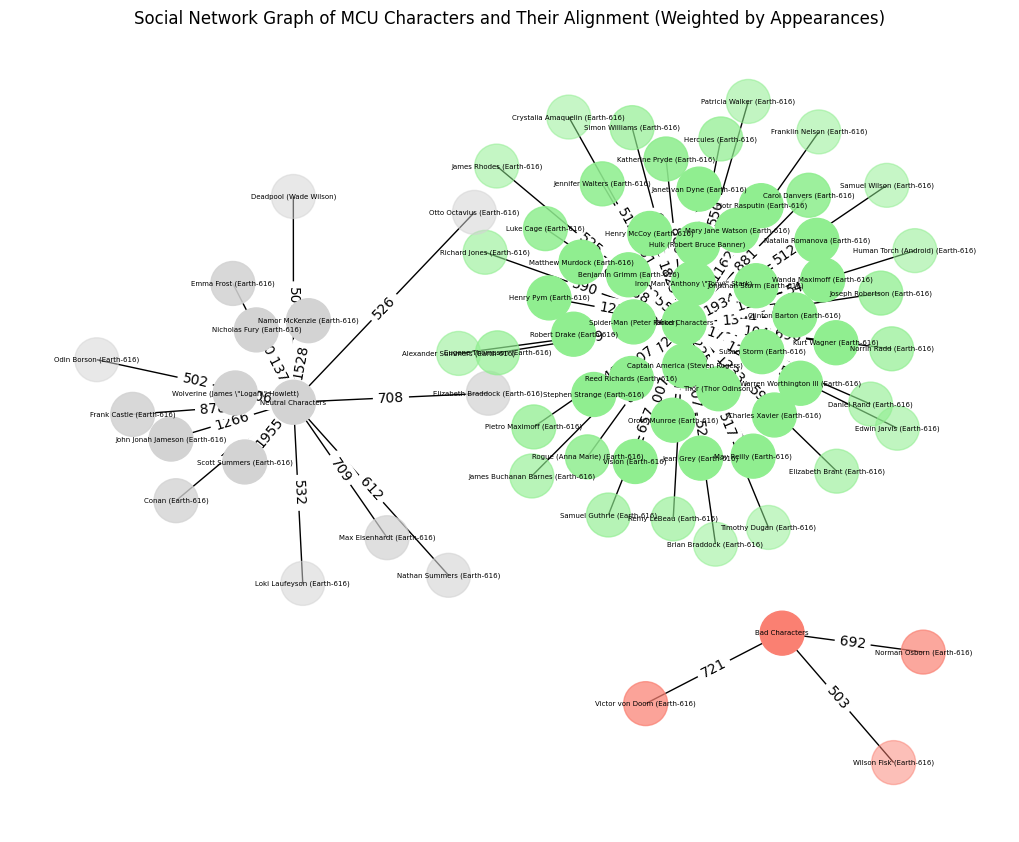

In [11]:
color_mapping = {
    'Good Characters': 'lightgreen',
    'Bad Characters': 'salmon',
    'Neutral Characters': 'lightgray'
}

G_bipartite = nx.Graph()

for alignment in ['Good Characters', 'Bad Characters', 'Neutral Characters']:
    G_bipartite.add_node(alignment, bipartite=0)

characters = character_alignment['name'].unique()
for character in characters:
    G_bipartite.add_node(character, bipartite=1)

for alignment in ['Good Characters', 'Bad Characters', 'Neutral Characters']:
    alignment_characters = character_alignment[character_alignment['ALIGN'] == alignment]
    for _, row in alignment_characters.iterrows():
        character = row['name']
        weight = row['APPEARANCES']
        G_bipartite.add_edge(alignment, character, weight=weight)

for node in list(G_bipartite.nodes()): #removing all with less than 500 appearances
    if G_bipartite.nodes[node]['bipartite'] == 1:  # Check if the node is a character
        appearances = sum(character_alignment[character_alignment['name'] == node]['APPEARANCES'])
        if appearances < 500:
            G_bipartite.remove_node(node)

np.random.seed(20)
pos = nx.spring_layout(G_bipartite, k=1.5, iterations=20)


node_colors = []
for node in G_bipartite.nodes():
    if node in color_mapping:  # Assign colors to alignment nodes
        node_colors.append(color_mapping[node])
    else:  # Assign colors to character nodes
        alignment = [n for n in G_bipartite.neighbors(node) if n in color_mapping][0]  # Get the alignment of the character
        appearances = sum(character_alignment[character_alignment['name'] == node]['APPEARANCES'])
        alpha = min(1, appearances / 1000)  # Scale appearances to fit within the range [0, 1]
        color = mcolors.to_rgba(color_mapping[alignment], alpha=alpha)  # Set alpha level based on appearances
        node_colors.append(color)

plt.figure(figsize=(10, 8))
nx.draw(G_bipartite, pos, with_labels=True, node_color=node_colors, node_size=1000, font_size=5)
nx.draw_networkx_edge_labels(G_bipartite, pos, edge_labels=nx.get_edge_attributes(G_bipartite, 'weight'))
plt.title('Social Network Graph of MCU Characters and Their Alignment (Weighted by Appearances)')
plt.show()


To reduce the data, I decided to analyze only data from which characters made  500 or more appearances. This network graph layout is an effective way to repel the nodes, while still maintaining all of the data.

In [12]:
print(character_alignment.sort_values(by='APPEARANCES', ascending=False).head())

                                  name               ALIGN  APPEARANCES
0            Spider-Man (Peter Parker)     Good Characters         4043
1      Captain America (Steven Rogers)     Good Characters         3360
2  Wolverine (James \"Logan\" Howlett)  Neutral Characters         3061
3    Iron Man (Anthony \"Tony\" Stark)     Good Characters         2961
4                  Thor (Thor Odinson)     Good Characters         2258


To map the top 10 appearances as a social network, I first reordered the dataframe. I was then able to take the top 10 names, alignments, and appearances and map them as a social network like so:

In [13]:
print(character_alignment.sort_values(by='APPEARANCES', ascending=False).head(10))

                                  name               ALIGN  APPEARANCES
0            Spider-Man (Peter Parker)     Good Characters         4043
1      Captain America (Steven Rogers)     Good Characters         3360
2  Wolverine (James \"Logan\" Howlett)  Neutral Characters         3061
3    Iron Man (Anthony \"Tony\" Stark)     Good Characters         2961
4                  Thor (Thor Odinson)     Good Characters         2258
5           Benjamin Grimm (Earth-616)     Good Characters         2255
6            Reed Richards (Earth-616)     Good Characters         2072
7           Hulk (Robert Bruce Banner)     Good Characters         2017
8            Scott Summers (Earth-616)  Neutral Characters         1955
9           Jonathan Storm (Earth-616)     Good Characters         1934


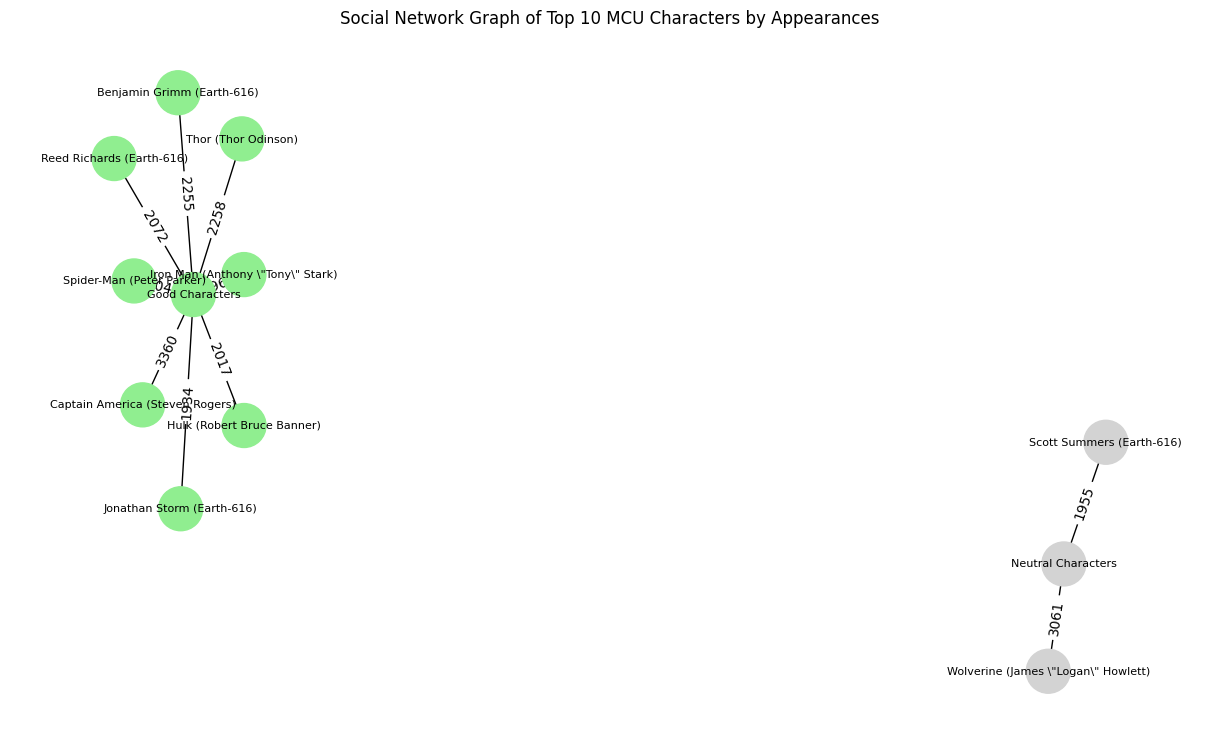

In [14]:
top_10_characters = character_alignment.sort_values(by='APPEARANCES', ascending=False).head(10)

G_bipartite = nx.Graph()

for character in top_10_characters['name']:
    G_bipartite.add_node(character, bipartite=1)

for _, row in top_10_characters.iterrows():
    character = row['name']
    alignment = row['ALIGN']
    weight = row['APPEARANCES']
    G_bipartite.add_edge(alignment, character, weight=weight)

color_mapping = {
    'Good Characters': 'lightgreen',
    'Bad Characters': 'salmon',
    'Neutral Characters': 'lightgray'
}

node_colors = []
for node in G_bipartite.nodes():
    if node in color_mapping:
        node_colors.append(color_mapping[node])
    else:  # Assign colors to character nodes
        alignment = [n for n in G_bipartite.neighbors(node) if n in color_mapping][0]  # Get the alignment of the character
        appearances = sum(character_alignment[character_alignment['name'] == node]['APPEARANCES'])
        alpha = min(1, appearances / 1000)  # Scale appearances to fit within the range [0, 1]
        color = mcolors.to_rgba(color_mapping[alignment], alpha=alpha)  # Set alpha level based on appearances
        node_colors.append(color)

np.random.seed(3)
pos = nx.fruchterman_reingold_layout(G_bipartite)

plt.figure(figsize=(12, 7))
nx.draw(G_bipartite, pos, with_labels=True, node_color=node_colors, node_size=1000, font_size=8)
nx.draw_networkx_edge_labels(G_bipartite, pos, edge_labels=nx.get_edge_attributes(G_bipartite, 'weight'))
plt.title('Social Network Graph of Top 10 MCU Characters by Appearances')
plt.show()


When looking at the alignment of the top 10 characters based on their appearance, we notice that there are bad characters missing. There are two neutral characters -- Wolverine and Scott Summers, which are in the top 10 characters with the most appearances. Additionally, there are eight good characters in the top 10 MCU appearances -- Spiderman, Captain America, Hulk,  Iron Man, Thor, Jonathan Storm, Reed Richards, and Benjamin Grimm.

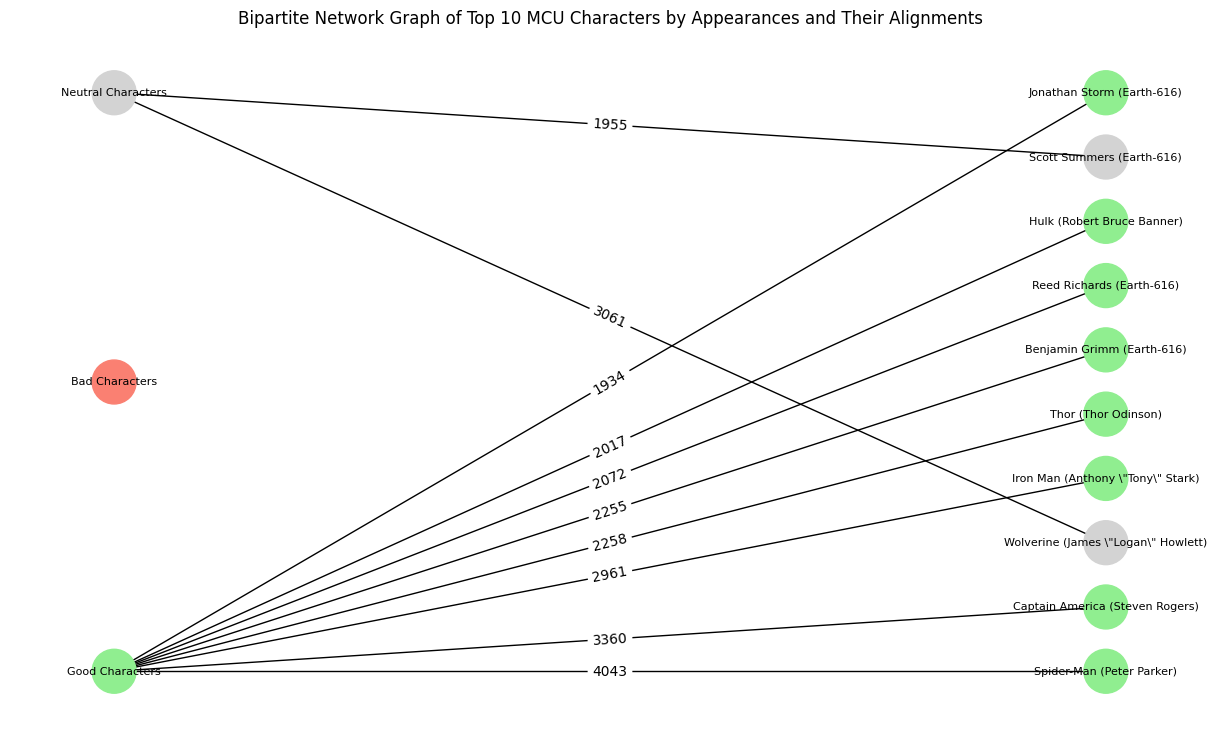

In [15]:
top_10_characters = character_alignment.sort_values(by='APPEARANCES', ascending=False).head(10)

G_bipartite = nx.Graph()

for alignment in ['Good Characters', 'Bad Characters', 'Neutral Characters']:
    G_bipartite.add_node(alignment, bipartite=0)

for character in top_10_characters['name']:
    G_bipartite.add_node(character, bipartite=1)

for _, row in top_10_characters.iterrows():
    character = row['name']
    alignment = row['ALIGN']
    weight = row['APPEARANCES']
    G_bipartite.add_edge(alignment, character, weight=weight)

color_mapping = {
    'Good Characters': 'lightgreen',
    'Bad Characters': 'salmon',
    'Neutral Characters': 'lightgray'
}

node_colors = []
for node in G_bipartite.nodes():
    if node in color_mapping:
        node_colors.append(color_mapping[node])
    else:  # Assign colors to character nodes
        alignment = [n for n in G_bipartite.neighbors(node) if n in color_mapping][0]  # Get the alignment of the character
        appearances = sum(character_alignment[character_alignment['name'] == node]['APPEARANCES'])
        alpha = min(1, appearances / 1000)  # Scale appearances to fit within the range [0, 1]
        color = mcolors.to_rgba(color_mapping[alignment], alpha=alpha)  # Set alpha level based on appearances
        node_colors.append(color)

np.random.seed(3)

pos = nx.bipartite_layout(G_bipartite, [alignment for alignment in ['Good Characters', 'Bad Characters', 'Neutral Characters']])

plt.figure(figsize=(12, 7))
nx.draw(G_bipartite, pos, with_labels=True, node_color=node_colors, node_size=1000, font_size=8)
nx.draw_networkx_edge_labels(G_bipartite, pos, edge_labels=nx.get_edge_attributes(G_bipartite, 'weight'))
plt.title('Bipartite Network Graph of Top 10 MCU Characters by Appearances and Their Alignments')
plt.show()

Using the top 10 MCU character appearance, the bipartite network graph is much easier to look at. We have the two groups which we are compared, separated on either side. The nodes and edges are  both labeled and annotated.

# Centrality
## Degree Centrality



In [16]:
character_degree_centrality = nx.degree_centrality(G_bipartite)
print("Degree Centrality for Top 10 MCU Characters:")
for character, centrality in character_degree_centrality.items():
    print(f"{character}: {centrality}")

Degree Centrality for Top 10 MCU Characters:
Good Characters: 0.6666666666666666
Bad Characters: 0.0
Neutral Characters: 0.16666666666666666
Spider-Man (Peter Parker): 0.08333333333333333
Captain America (Steven Rogers): 0.08333333333333333
Wolverine (James \"Logan\" Howlett): 0.08333333333333333
Iron Man (Anthony \"Tony\" Stark): 0.08333333333333333
Thor (Thor Odinson): 0.08333333333333333
Benjamin Grimm (Earth-616): 0.08333333333333333
Reed Richards (Earth-616): 0.08333333333333333
Hulk (Robert Bruce Banner): 0.08333333333333333
Scott Summers (Earth-616): 0.08333333333333333
Jonathan Storm (Earth-616): 0.08333333333333333


The degree centrality measures for the characters and alignments in the Marvel Cinematic Universe bipartite network, gives us insight into their importance as a character (relative to one another) and their connectivity within the social network. With the characters who made the top 10 appearances, among the alignments, "Good Characters" exhibit the highest degree centrality, indicating  extensive connections to various character nodes, "Bad Characters" have a degree centrality of 0, meaning no direct connections to any character nodes, and "Neutral Characters" fall in between, with moderate degree centrality. Individual characters such as Spider-Man, Captain America, and Iron Man demonstrate relatively high degree centrality values, demonstrating their prominence within the MCU character network. Characters with lower degree centrality values are less influential.

# Eigenvector Centrality

In [17]:
character_eigenvector_centrality = nx.eigenvector_centrality(G_bipartite)
print("Eigenvector Centrality:")
for character, centrality in character_eigenvector_centrality.items():
    print(f"{character}: {centrality}")


Eigenvector Centrality:
Good Characters: 0.7071067744546118
Bad Characters: 3.758420629468418e-15
Neutral Characters: 6.972162826884136e-06
Spider-Man (Peter Parker): 0.25000000235579317
Captain America (Steven Rogers): 0.25000000235579317
Wolverine (James \"Logan\" Howlett): 4.930063614426541e-06
Iron Man (Anthony \"Tony\" Stark): 0.25000000235579317
Thor (Thor Odinson): 0.25000000235579317
Benjamin Grimm (Earth-616): 0.25000000235579317
Reed Richards (Earth-616): 0.25000000235579317
Hulk (Robert Bruce Banner): 0.25000000235579317
Scott Summers (Earth-616): 4.930063614426541e-06
Jonathan Storm (Earth-616): 0.25000000235579317


Eigenvector centrality can measure the significance of a node in a network based on its associations to other influential nodes. In the context of the Marvel Cinematic Universe social network, the eigenvector centrality scores reveal the influence of different alignment groups and characters within the network. The highest score is the "Good Characters" group, indicating that these characters are strongly connected to other influential characters in the network. Conversely, "Bad Characters" and "Neutral Characters" exhibit significantly lower eigenvector centrality scores, suggesting limited influence and connectivity. Among individual characters, those like Spider-Man, Captain America, Iron Man, Thor, and others have moderate eigenvector centrality scores, indicating they are connected to some influential characters within the network. Overall, characters with higher eigenvector centrality scores are likely to play more significant roles and have more influence within the MCU social network, while those with lower scores are less central to the network's structure.

# Conclusions and Inference

The analyses of the bipartite graph, social network graph, eigenvector centrality, and degree centrality in the Marvel Cinematic Universe social network offers valuable insights into the network's structure and the significance of its characters and alignment groups. Eigenvector centrality highlights the importance of influential nodes, with "Good Characters" grouped as the most influential group, indicating strong connections to other characters. Conversely, "Bad Characters" and "Neutral Characters" exhibit lower eigenvector centrality scores, implying limited influence and connectivity. Among the individual characters, those like Spider-Man, Captain America, Iron Man, and Thor have the highest eigenvector centrality scores, suggesting that they are connected to/are the most influential characters. Degree centrality complements this by illustrating characters' relative importance and connectivity within the network. When looking at the top 10 characters based on appearances, characters aligned with "Good Characters" display the highest degree centrality, while no "Bad Characters" are directly connected when looking at the top 10. Individual characters such as Spider-Man, Captain America, and Iron Man demonstrate notable prominence, as evidenced by their high degree centrality values. Overall, these findings suggest a hierarchical structure which is dominated by characters aligned with being good. This, coupled with the fact that these are characters with the most appearances, suggests that viewers prefer superheroes over supervillain characters. Inspired by the fact that most of these top characters are in The Avengers, in the future, I would add to this study a new worth category to determine if superheroes sell better than supervillains or neutral characters, along with a correlation analysis. I would also like to review more recent data in addition to this, and look at the co-occurance of superheroes and supervillains in these movies.  

### Presentation Link
https://youtu.be/--DvZIurfVQ